In [1]:
import h5py
import jax.numpy as jnp
import numpy as np
import healpy as hp
from functools import partial
import jax
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings('ignore')

In [2]:
fiducial = True #wether we use fiducial datat or grid dataset

In [3]:
sim_nb = 4 # simulation number from 0 to 6

filename = "../cosmogrid_data/CosmoGridV1_metainfo.h5"
# filename = "/gpfsdswork/dataset/CosmoGridV1/CosmoGridV1_metainfo.h5"

f = h5py.File(filename, "r")

if fiducial: 
    dataset_grid = f["parameters"]["fiducial"]
else: 
    dataset_grid = f['parameters']['grid']

# if fiducial: 
#     path_string = "/gpfsdswork/dataset/CosmoGridV1/stage3_forecast/fiducial/cosmo_fiducial/"
# else:
#     path_string = '/gpfsdswork/dataset/' + dataset_grid['path_par'][0].decode('utf-8').replace('CosmoGrid', 'CosmoGridV1').replace('raw', 'stage3_forecast')

if fiducial: 
    path_string = "../cosmogrid_data/"
else:
    path_string = '../' + dataset_grid['path_par'][0].decode('utf-8').replace('CosmoGrid', '../cosmogrid_data').replace('raw', 'stage3_forecast')
    
filename = path_string + 'perm_000' + str(sim_nb) 
filename_baryon = filename + '/projected_probes_maps_baryonified512.h5'
filename_withouth_baryon = filename + '/projected_probes_maps_nobaryons512.h5'
sim_with_baryon = h5py.File(filename_baryon, "r")
sim_without_baryon = h5py.File(filename_withouth_baryon, "r")

 Because we force the decoder to have the same power spectrum as the gaussian latent space we have to make sure that our nbody sims share the same power spectrum as Gaussian sims for this experiment we use only 1 spherical nobody sim

In [4]:
# config

nside = 512
mean_pixel_area = 4 * np.pi / hp.nside2npix(nside)
scaling_factor = 1 / mean_pixel_area
map_size = size = 10 # Size of square in degrees
master_key = jax.random.PRNGKey(0)

In [5]:
# Computing map size given nside and total area

pixel_area_square_degrees = hp.nside2pixarea(nside,  degrees=True)
print("Area of one pixel:", pixel_area_square_degrees, "deg^2")

npix = hp.nside2npix(nside)

# Calculate the total area covered by one map
total_area_square_degrees = npix * pixel_area_square_degrees

print("Total area covered by one map:", total_area_square_degrees, "deg^2")

# Desired total area in square degrees
desired_total_area_square_degrees = map_size**2 # deg^2
print("Desired area:", desired_total_area_square_degrees, "deg^2")

# Calculate the number of pixels required to cover the desired total area
num_pixels_required = desired_total_area_square_degrees / pixel_area_square_degrees

print("Number of pixels required to cover 10 square degrees:", int(num_pixels_required))

N = int(np.sqrt(num_pixels_required))
print("Map width in pixels", N)

N = 86 # Let's use an even pixel width

xsize = N
reso = size * 60 / xsize
reso_rad = reso / 60 / 180 * jnp.pi
print("resoulion:", reso, "arcmin")

Area of one pixel: 0.013113963206424481 deg^2
Total area covered by one map: 41252.96124941927 deg^2
Desired area: 100 deg^2
Number of pixels required to cover 10 square degrees: 7625
Map width in pixels 87
resoulion: 6.976744186046512 arcmin


In [6]:
cosmo_parameters = jnp.array([
            dataset_grid['Om'],
            dataset_grid['s8'],
            dataset_grid['w0'],
            dataset_grid['H0'],
            dataset_grid['ns'],
            dataset_grid['Ob']
        ]).T

nb_of_projected_map = 200
master_key = jax.random.PRNGKey(6)
key, master_key = jax.random.split(master_key)

# keeping only last tomo bins
nbody_map_without_baryon = np.array(sim_without_baryon['kg']['stage3_lensing{}'.format(4)])

# building gaussian map
lmax = 3*nside - 1
power_spectrum_nbody_map = hp.sphtfunc.anafast(nbody_map_without_baryon, lmax = lmax)
z = np.random.randn(hp.nside2npix(nside)) * np.sqrt(scaling_factor) 
power_spectrum_noise =  hp.sphtfunc.anafast(z, lmax = lmax)
power_spectrum_target = power_spectrum_nbody_map / power_spectrum_noise
alm_hp = hp.map2alm(z, lmax = lmax)
alm = hp.sphtfunc.almxfl(alm_hp, np.sqrt(power_spectrum_target))
gaussian_map = hp.alm2map(alm, nside, lmax = lmax)

# center both gaussian and nbody maps
gaussian_map = gaussian_map - gaussian_map.mean()
nbody_map_without_baryon = nbody_map_without_baryon - nbody_map_without_baryon.mean()

# projection
key1, key2 = jax.random.split(key)
lon = jax.random.randint(key1,(nb_of_projected_map,),-180, 180)
lat = jax.random.randint(key2, (nb_of_projected_map,), -90, 90)
projection_nbody_store=[]
projection_gaussian_store=[]

for k in range(nb_of_projected_map):
    proj = hp.projector.GnomonicProj(rot=[lon[k], lat[k], 0], xsize=xsize, ysize=xsize, reso=reso)
    
    projection_nbody = proj.projmap(nbody_map_without_baryon, vec2pix_func=partial(hp.vec2pix, nside))
    projection_nbody_store.append(projection_nbody)

    projection_gaussian = proj.projmap(gaussian_map, vec2pix_func=partial(hp.vec2pix, nside))
    projection_gaussian_store.append(projection_gaussian)

-8.989278324894138e-18
7.0583988e-09


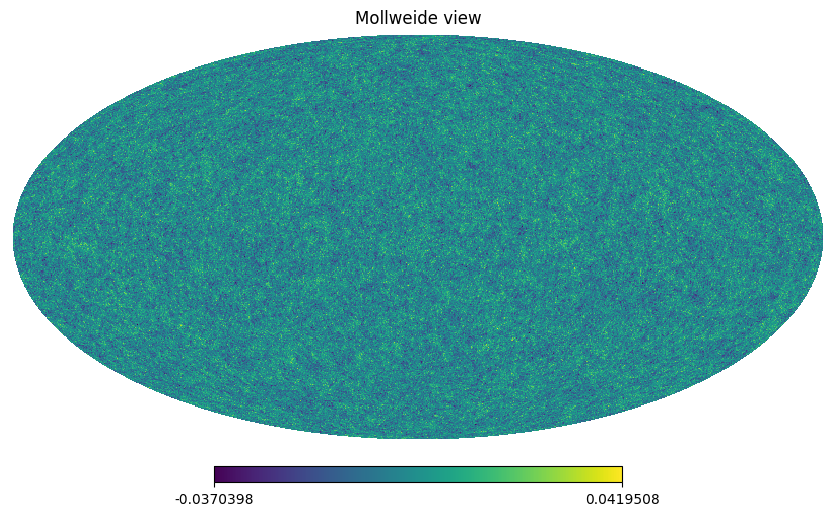

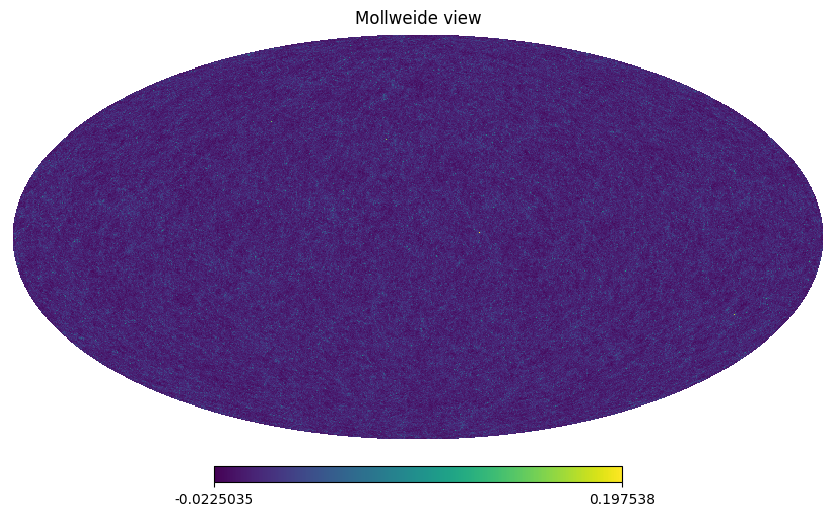

In [7]:
hp.mollview(gaussian_map)
hp.mollview(nbody_map_without_baryon)

print(gaussian_map.mean())
print(nbody_map_without_baryon.mean())

In [8]:
from jax.tree_util import register_pytree_node_class
from jax_cosmo.redshift import redshift_distribution
import numpyro.distributions as dist
import jax_cosmo as jc
np.float = float
np.complex = complex


# Create our fiducial observations
pix_area = (map_size * 60 / N) ** 2  # arcmin2
map_size_rad = map_size / 180 * jnp.pi  # radians

galaxy_density = gal_per_arcmin2 = 10/4
sigma_e = 0.26



@register_pytree_node_class
class smail_nz2(redshift_distribution):
    def pz_fn(self, z):
        a, b, z0 = self.params
        return z**a * jnp.exp(-((z / z0) ** b))*4

In [9]:
cosmo_params_c = {"Om": cosmo_parameters[sim_nb][0], 
                  "s8": cosmo_parameters[sim_nb][1], 
                  "w0": cosmo_parameters[sim_nb][2], 
                  "h": cosmo_parameters[sim_nb][3]/100, 
                  "ns": cosmo_parameters[sim_nb][4],
                  "Ob": cosmo_parameters[sim_nb][5]
                  }

In [10]:
# def get_cell_theory(type='angular_cl'):
# ell_theory = jnp.linspace(60, 2000, 15)  
l_edges_kmap = np.arange(60.0, lmax, 15.0)
ell_theory = l_edges_kmap

cosmo = jc.Planck15(
    Omega_c=cosmo_params_c["Om"] - cosmo_params_c["Ob"],
    Omega_b=cosmo_params_c["Ob"],
    h=cosmo_params_c["h"],
    n_s=cosmo_params_c["ns"],
    sigma8=cosmo_params_c["s8"],
    Omega_k=0.0,
    w0=cosmo_params_c["w0"],
    wa=0.0,
)
pz = smail_nz2(3.53, 4.49, 1.03, gals_per_arcmin2=galaxy_density)
tracer = jc.probes.WeakLensing([pz])

cell_theory = jc.angular_cl.angular_cl(cosmo, ell_theory, [tracer])
cell_theory = cell_theory[0]

Let's apply the pixel window corresponding to nside $=512$ and a hard scale cut at
$\ell=1000$, where the Cosmogrid maps start to differ from the theory

In [11]:
# Pixel window
pixel_window = jnp.array(hp.sphtfunc.pixwin(nside=nside), dtype='float32')

def pixel_window_fn(ell):
    return pixel_window[ell.astype('int32')]

# Scale cut
def scale_cut_fn(ell, ell_cut=1000):
    return jnp.ones(lmax+1)[ell.astype('int32')].at[jnp.where(ell>ell_cut)].set(0)

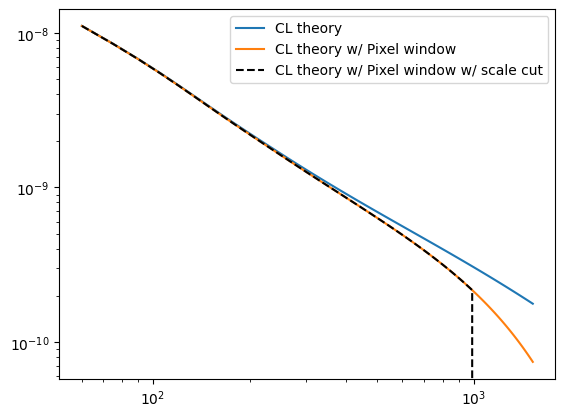

In [12]:
plt.loglog(ell_theory, cell_theory, label="CL theory")
plt.loglog(ell_theory, cell_theory*pixel_window_fn(ell_theory)**2, label="CL theory w/ Pixel window")
plt.loglog(ell_theory, scale_cut_fn(ell_theory, 1000)*cell_theory*pixel_window_fn(ell_theory)**2,
           '--', c='k', label="CL theory w/ Pixel window w/ scale cut")
plt.legend()

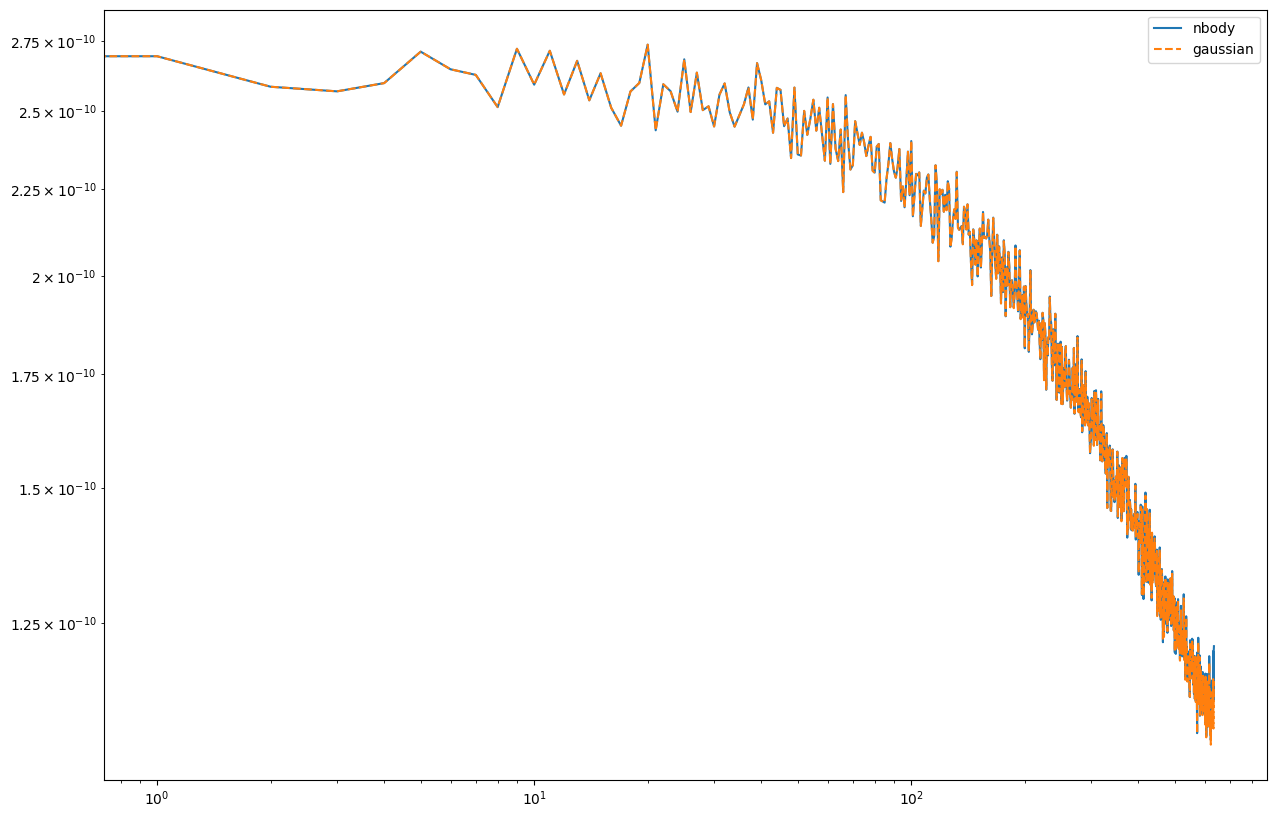

In [13]:
plt.figure(figsize=(15,10))
i = 900
power_spectrum_gaussian_map = hp.sphtfunc.anafast(gaussian_map, lmax = lmax)
power_spectrum_nbody_map = hp.sphtfunc.anafast(nbody_map_without_baryon, lmax = lmax)

plt.loglog(power_spectrum_nbody_map[i:], label = 'nbody')
plt.loglog(power_spectrum_gaussian_map[i:], '--',label = 'gaussian')
plt.legend()

In [14]:
np.complex = np.complex64
np.float = np.float32

Ooooooooook the power spectrums are the same 🥳

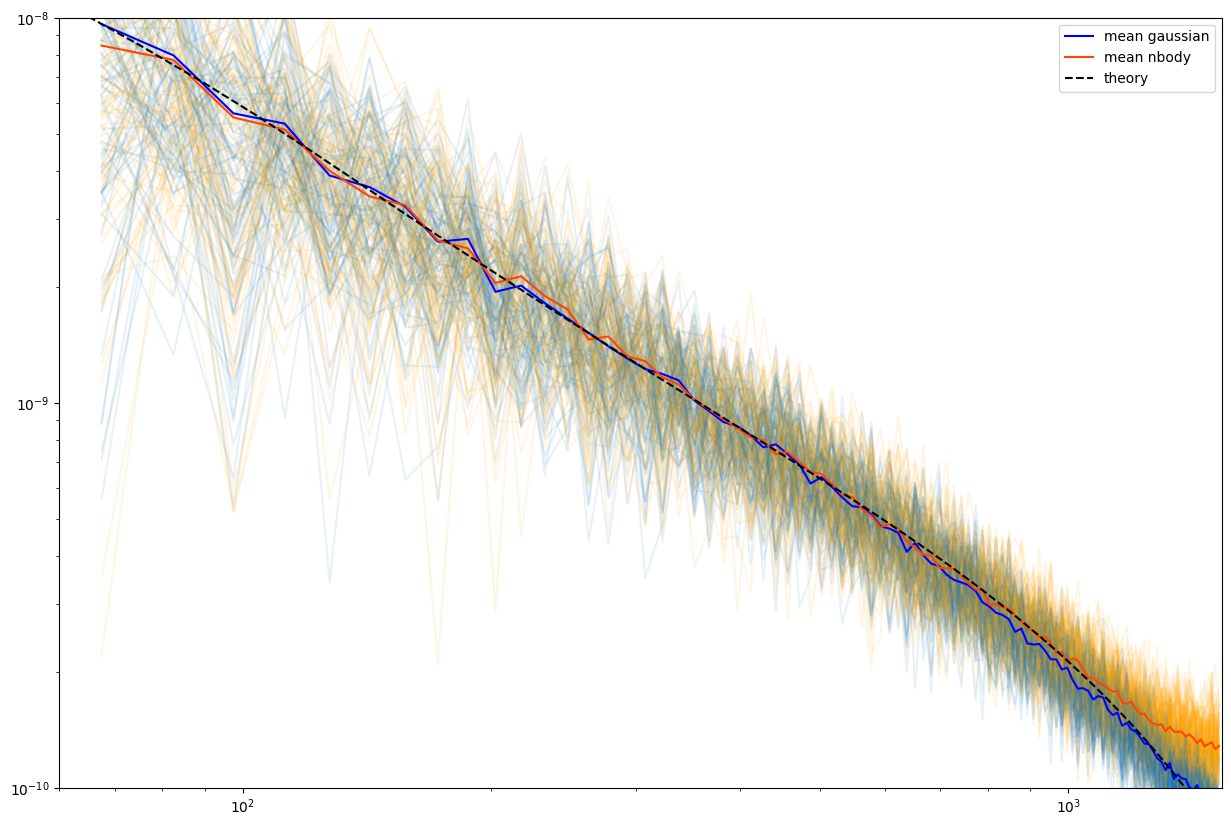

In [15]:
import astropy.units as u
from lenstools import ConvergenceMap
import numpy as np

plt.figure(figsize=(15,10))

# l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
l_edges_kmap = np.arange(60.0, lmax, 15.0)

store_ps_gaussian = []
store_ps_nbody = []
for i in range(0, nb_of_projected_map//2):
    ell, ps = ConvergenceMap(projection_gaussian_store[i], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)
    ell2, ps2 = ConvergenceMap(projection_nbody_store[i], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)

    store_ps_gaussian.append(ps)
    store_ps_nbody.append(ps2)
    plt.loglog(ell,ps, alpha = 0.1, color='C0')
    plt.loglog(ell, ps2, alpha = 0.1, color='orange')

plt.loglog(ell, jnp.mean(jnp.array(store_ps_gaussian), axis = 0),  color='blue', label = 'mean gaussian')
plt.loglog(ell, jnp.mean(jnp.array(store_ps_nbody), axis = 0),  color='orangered', label = 'mean nbody')
plt.loglog(ell_theory, cell_theory*pixel_window_fn(ell_theory)**2, '--', c='k', label='theory')
plt.xlim([60, lmax])
plt.ylim([1e-10, 1e-8])
plt.legend()

This is weird, it should be the same after projection 🤔 

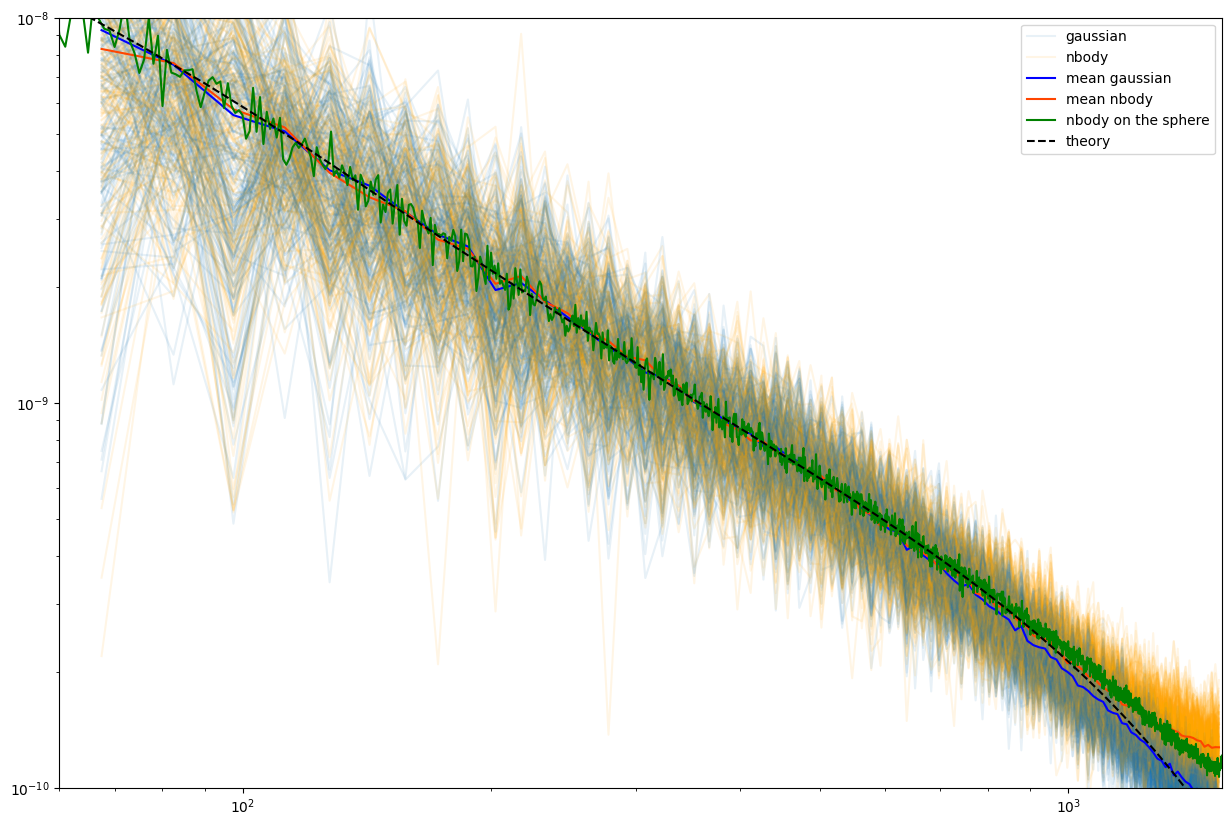

In [16]:
import astropy.units as u
from lenstools import ConvergenceMap
import numpy as np

plt.figure(figsize=(15,10))

# l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
l_edges_kmap = np.arange(60.0, lmax, 15.0)

ell, ps = ConvergenceMap(projection_gaussian_store[0], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)
ell2, ps2 = ConvergenceMap(projection_nbody_store[0], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)
plt.loglog(ell,ps, alpha = 0.1, color='C0', label ='gaussian')
plt.loglog(ell2, ps2, alpha = 0.1, color='orange',label ='nbody')

store_ps_gaussian = []
store_ps_nbody = []
for i in range(1, nb_of_projected_map):
    ell, ps = ConvergenceMap(projection_gaussian_store[i], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)
    ell2, ps2 = ConvergenceMap(projection_nbody_store[i], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)
    store_ps_gaussian.append(ps)
    store_ps_nbody.append(ps2)
    plt.loglog(ell,ps, alpha = 0.1, color='C0')
    plt.loglog(ell2, ps2, alpha = 0.1, color='orange')

plt.loglog(ell, jnp.mean(jnp.array(store_ps_gaussian), axis = 0),  color='blue', label = 'mean gaussian')
plt.loglog(ell, jnp.mean(jnp.array(store_ps_nbody), axis = 0),  color='orangered', label = 'mean nbody')
plt.legend()

i = 0
plt.loglog(power_spectrum_nbody_map[i:], color='green', label = 'nbody on the sphere')
plt.loglog(ell_theory, cell_theory*pixel_window_fn(ell_theory)**2, '--', c='k', label='theory')
plt.xlim([60, lmax])
plt.ylim([1e-10, 1e-8])
plt.legend()

# hline()

Super weird why is the true power spectrum from the map on the sphere closer to the gaussian power spectrum 😩

Ok lets also check how the gaussian prior behaves

In [17]:
def Pk_fn(k, cosmo, a_ai=None, pixel_window=True, scale_cut=1000):
    pz = smail_nz2(3.53, 4.49, 1.03, gals_per_arcmin2=galaxy_density)
    tracer = jc.probes.WeakLensing([pz], ia_bias=a_ai)
    ell_tab = jnp.logspace(0, 4.5, 128)
    cell_tab = jc.angular_cl.angular_cl(cosmo, ell_tab, [tracer])[0]
    if pixel_window is True:
        cell_tab *= pixel_window_fn(ell_tab)**2
    if scale_cut is not None:
        cell_tab *= scale_cut_fn(ell_tab, scale_cut)
    return jc.scipy.interpolate.interp(k.flatten(), ell_tab, cell_tab).reshape(k.shape)


def make_power_map(pk_fn, N, field_size, zero_freq_val=0.0):
    k = 2 * jnp.pi * jnp.fft.fftfreq(N, d=field_size / N)
    kcoords = jnp.meshgrid(k, k)
    k = jnp.sqrt(kcoords[0] ** 2 + kcoords[1] ** 2)
    ps_map = pk_fn(k)
    ps_map = ps_map.at[0, 0].set(zero_freq_val)
    return ps_map * (N / field_size) ** 2

def gaussian_forward_model():
    Om = numpyro.sample("Om", dist.Uniform(0.1,0.5))
    s8 = numpyro.sample("s8", dist.Uniform(0.4,1.4))
    h = numpyro.sample("h", dist.Uniform(0.64, 0.82))
    Ob = numpyro.sample("Ob", dist.Uniform(0.03,0.06))
    ns = numpyro.sample("ns", dist.Uniform(0.87, 1.07))
    w0 = numpyro.sample("w0", dist.Uniform(-2.0, -0.333))
    
    z = numpyro.sample(
        "z", dist.MultivariateNormal(loc=jnp.zeros((N, N)), precision_matrix=jnp.eye(N))
    )
    
    cosmo = jc.Planck15(
        Omega_c=Om - Ob,
        Omega_b=Ob,
        h=h,
        n_s=ns,
        sigma8=s8,
        Omega_k=0.0,
        w0=w0,
        wa=0.0,
    )
    
    P = partial(Pk_fn, cosmo=cosmo, a_ai=None)
    power_map = make_power_map(P, N, map_size_rad)
    
    gaussian_map = jnp.fft.ifft2(jnp.fft.fft2(z) * jnp.sqrt(power_map)).real
    x = numpyro.deterministic("x", gaussian_map.squeeze())
    # x = numpyro.sample(
    #     "x",
    #     dist.Independent(
    #         dist.Normal(gaussian_map.squeeze(), sigma_e / jnp.sqrt(gal_per_arcmin2 * pix_area)), 2
    #     ),
    # )
    
    return x

In [18]:
import numpyro
fiducial_model = numpyro.handlers.condition(
    gaussian_forward_model, 
    {
        "Om": cosmo_parameters[sim_nb][0], 
        "s8": cosmo_parameters[sim_nb][1], 
        "w0": cosmo_parameters[sim_nb][2], 
        "h": cosmo_parameters[sim_nb][3]/100, 
        "ns": cosmo_parameters[sim_nb][4],
        "Ob": cosmo_parameters[sim_nb][5], 
    }
)

# @jax.jit
@jax.vmap
def get_sample_prior(key):
    model_trace = numpyro.handlers.trace(seed(fiducial_model, key)).get_trace()
    return model_trace['x']['value']#.mean

In [19]:
from numpyro.handlers import condition, reparam, seed, trace
gaussian_map_prior_store = get_sample_prior(
    jax.random.split(jax.random.PRNGKey(123), nb_of_projected_map)
)

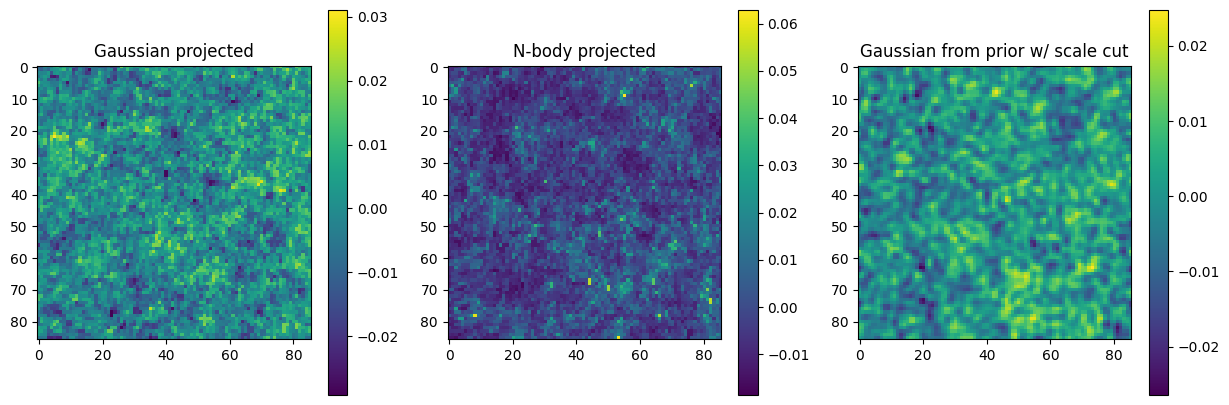

In [20]:
plt.figure(figsize=(3*5,5))
plt.subplot(131)
plt.title('Gaussian projected')
plt.imshow(projection_gaussian_store[0])
plt.colorbar()
plt.subplot(132)
plt.title('N-body projected')
plt.imshow(projection_nbody_store[0])
plt.colorbar()
plt.subplot(133)
plt.title('Gaussian from prior w/ scale cut')
plt.imshow(gaussian_map_prior_store[0])
plt.colorbar()

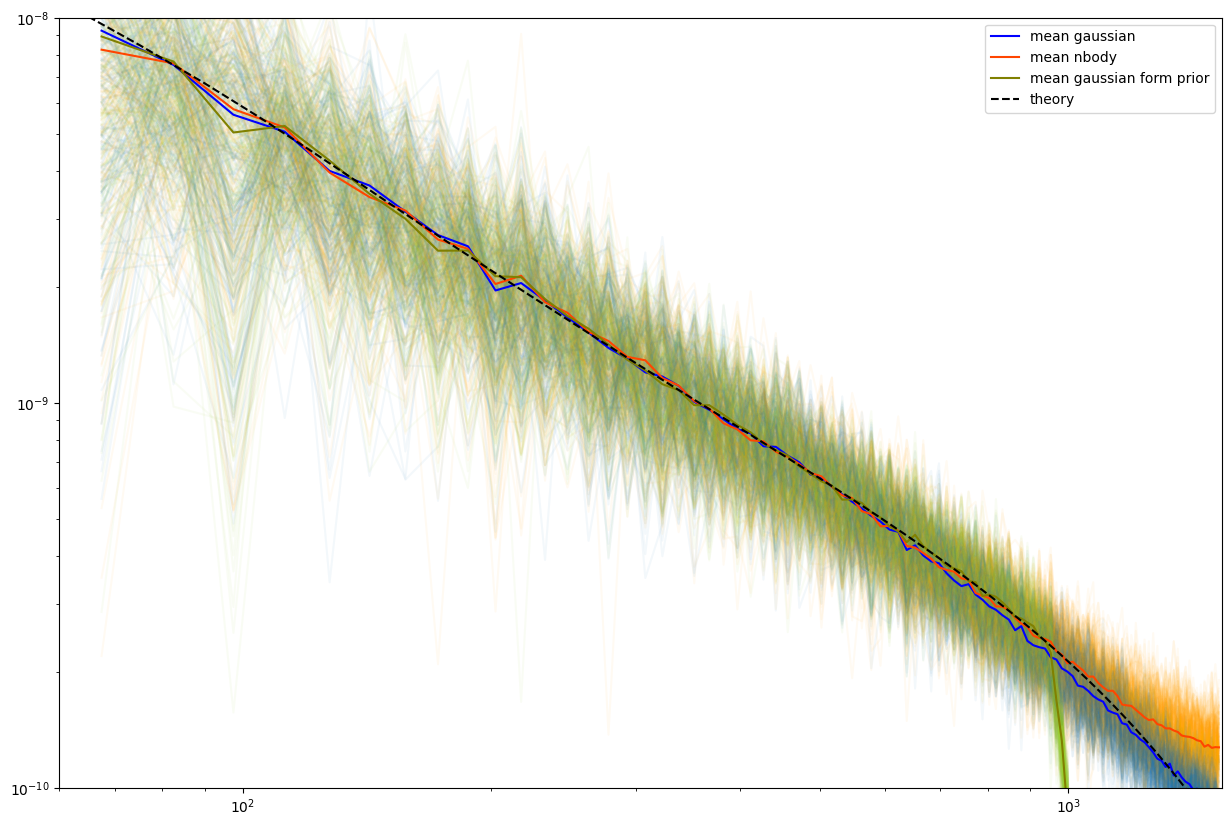

In [21]:
import astropy.units as u
from lenstools import ConvergenceMap
import numpy as np

plt.figure(figsize=(15,10))

l_edges_kmap = np.arange(60.0, lmax, 15.0)
alpha = 0.05


store_ps_gaussian = []
store_ps_nbody = []
store_ps_gaussian_prior=[]
for i in range(0, nb_of_projected_map):
    ell, ps = ConvergenceMap(projection_gaussian_store[i], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)
    ell2, ps2 = ConvergenceMap(projection_nbody_store[i], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)
    store_ps_gaussian.append(ps)
    store_ps_nbody.append(ps2)
    plt.loglog(ell,ps, alpha = alpha, color='C0')
    plt.loglog(ell2, ps2, alpha = alpha, color='orange')

    l, Pl = ConvergenceMap(gaussian_map_prior_store[i], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)
    store_ps_gaussian_prior.append(Pl)
    plt.loglog(l, Pl, alpha = alpha, c = 'yellowgreen')

plt.loglog(ell, jnp.mean(jnp.array(store_ps_gaussian), axis = 0),  color='blue', label = 'mean gaussian')
plt.loglog(ell, jnp.mean(jnp.array(store_ps_nbody), axis = 0),  color='orangered', label = 'mean nbody')
plt.loglog(l, jnp.mean(jnp.array(store_ps_gaussian_prior), axis = 0),  color='olive', label = 'mean gaussian form prior')
plt.loglog(ell_theory, cell_theory*pixel_window_fn(ell_theory)**2, '--', c='k', label="theory")
plt.xlim([60, lmax])
plt.ylim([1e-10, 1e-8])
plt.legend()

noise std 0.023569508


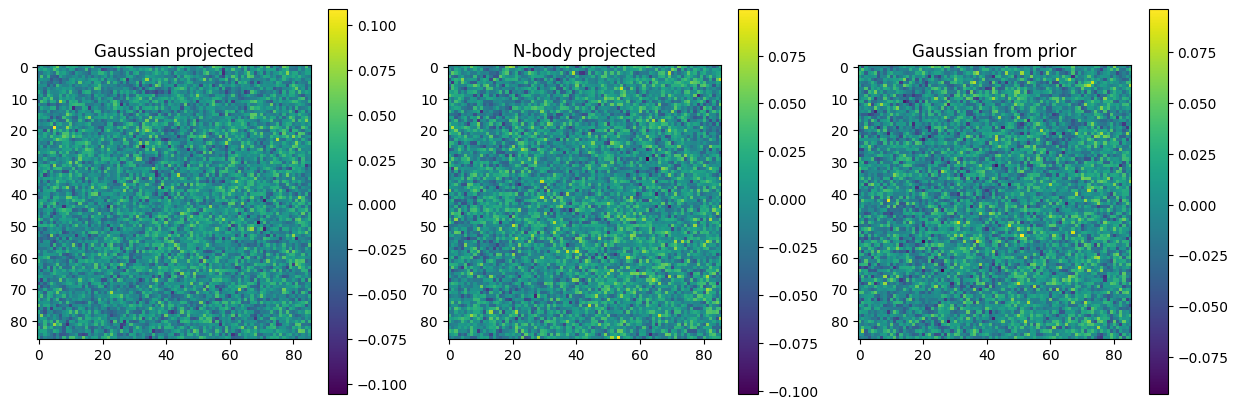

In [22]:
noise_std = sigma_e / jnp.sqrt(galaxy_density * (10 * 60 / N) ** 2)
print("noise std", noise_std)


plt.figure(figsize=(3*5,5))
plt.subplot(131)
plt.title('Gaussian projected')
plt.imshow(projection_gaussian_store[0]+np.random.randn(N,N)*noise_std)
plt.colorbar()
plt.subplot(132)
plt.title('N-body projected')
plt.imshow(projection_nbody_store[0]+np.random.randn(N,N)*noise_std)
plt.colorbar()
plt.subplot(133)
plt.title('Gaussian from prior')
plt.imshow(gaussian_map_prior_store[0]+np.random.randn(N,N)*noise_std)
plt.colorbar()

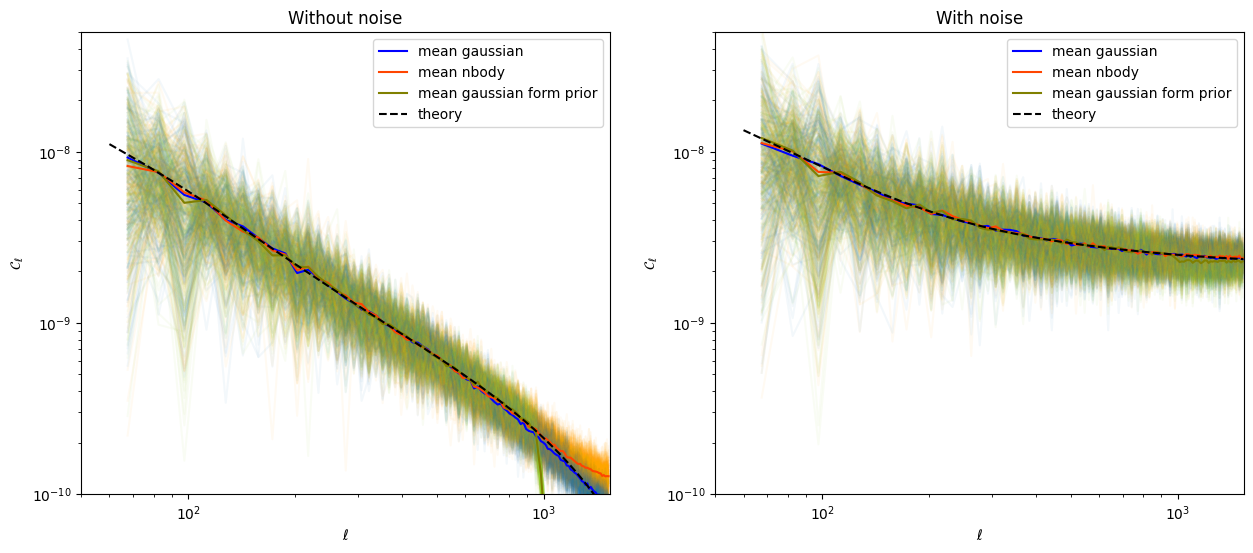

In [23]:
import astropy.units as u
from lenstools import ConvergenceMap
import numpy as np

plt.figure(figsize=(15,6))

plt.subplot(121)

l_edges_kmap = np.arange(60.0, lmax, 15.0)
alpha = 0.05


store_ps_gaussian = []
store_ps_nbody = []
store_ps_gaussian_prior=[]
for i in range(0, nb_of_projected_map):
    ell, ps = ConvergenceMap(projection_gaussian_store[i], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)
    ell2, ps2 = ConvergenceMap(projection_nbody_store[i], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)
    store_ps_gaussian.append(ps)
    store_ps_nbody.append(ps2)
    plt.loglog(ell,ps, alpha = alpha, color='C0')
    plt.loglog(ell2, ps2, alpha = alpha, color='orange')

    l, Pl = ConvergenceMap(gaussian_map_prior_store[i], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)
    store_ps_gaussian_prior.append(Pl)
    plt.loglog(l, Pl, alpha = alpha, c = 'yellowgreen')

plt.loglog(ell, jnp.mean(jnp.array(store_ps_gaussian), axis = 0),  color='blue', label = 'mean gaussian')
plt.loglog(ell, jnp.mean(jnp.array(store_ps_nbody), axis = 0),  color='orangered', label = 'mean nbody')
plt.loglog(l, jnp.mean(jnp.array(store_ps_gaussian_prior), axis = 0),  color='olive', label = 'mean gaussian form prior')
plt.loglog(ell_theory, cell_theory*pixel_window_fn(ell_theory)**2, '--', c='k', label="theory")
plt.xlim([50, lmax])
plt.ylim([1e-10, 5e-8])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\mathcal{C}_\ell$')
plt.title('Without noise')
plt.legend()

plt.subplot(122)
l_edges_kmap = np.arange(60.0, lmax, 15.0)
alpha = 0.05


store_ps_gaussian = []
store_ps_nbody = []
store_ps_gaussian_prior=[]
for i in range(0, nb_of_projected_map):
    ell, ps = ConvergenceMap(projection_gaussian_store[i]+np.random.randn(N,N)*noise_std, angle=map_size * u.deg).powerSpectrum(l_edges_kmap)
    ell2, ps2 = ConvergenceMap(projection_nbody_store[i]+np.random.randn(N,N)*noise_std, angle=map_size * u.deg).powerSpectrum(l_edges_kmap)
    store_ps_gaussian.append(ps)
    store_ps_nbody.append(ps2)
    plt.loglog(ell,ps, alpha = alpha, color='C0')
    plt.loglog(ell2, ps2, alpha = alpha, color='orange')

    l, Pl = ConvergenceMap(gaussian_map_prior_store[i]+np.random.randn(N,N)*noise_std, angle=map_size * u.deg).powerSpectrum(l_edges_kmap)
    store_ps_gaussian_prior.append(Pl)
    plt.loglog(l, Pl, alpha = alpha, c = 'yellowgreen')

cell_noise = jc.angular_cl.noise_cl(ell_theory, [tracer])[0]

plt.loglog(ell, jnp.mean(jnp.array(store_ps_gaussian), axis = 0),  color='blue', label = 'mean gaussian')
plt.loglog(ell, jnp.mean(jnp.array(store_ps_nbody), axis = 0),  color='orangered', label = 'mean nbody')
plt.loglog(l, jnp.mean(jnp.array(store_ps_gaussian_prior), axis = 0),  color='olive', label = 'mean gaussian form prior')
plt.loglog(ell_theory, cell_theory*pixel_window_fn(ell_theory)**2+cell_noise, '--', c='k', label="theory")
plt.xlim([50, lmax])
plt.ylim([1e-10, 5e-8])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\mathcal{C}_\ell$')
plt.title('With noise')
plt.legend()

# Scale cuts strategies

1. Rebbining to cut small ell

In [24]:
# Reshape the maps to desired resoluton
def rebin(kmap):
    field_npix = 43
    return kmap.reshape([
        field_npix, 
        2,  
        field_npix, 
        2 
    ]).mean(axis=1).mean(axis=-1)

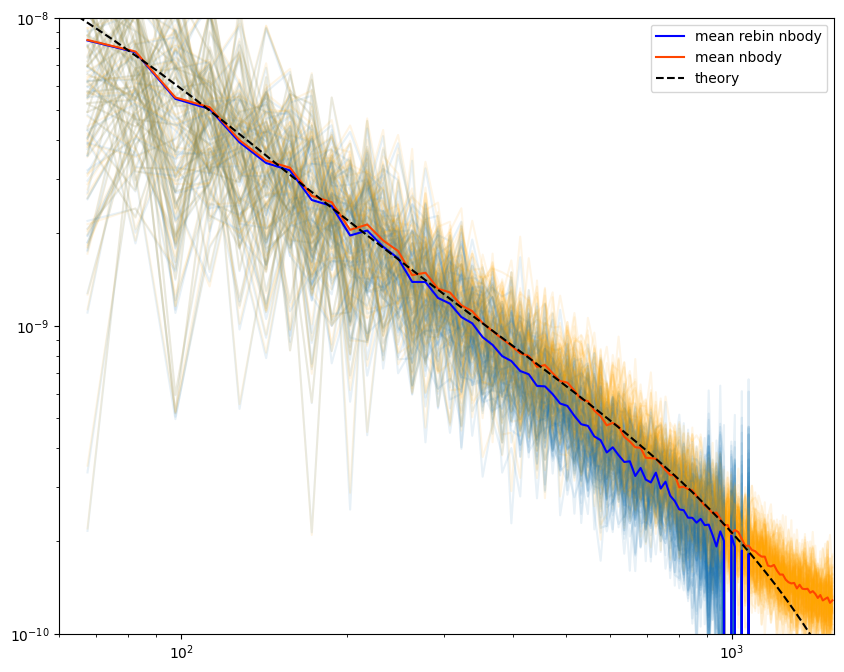

In [25]:
import astropy.units as u
from lenstools import ConvergenceMap
import numpy as np

plt.figure(figsize=(10,8))

# l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
l_edges_kmap = np.arange(60.0, lmax, 15.0)

store_ps_gaussian = []
store_ps_nbody = []
for i in range(0, nb_of_projected_map//2):
    rebin_projection_nbody_store = rebin(projection_nbody_store[i])
    ell, ps = ConvergenceMap(rebin_projection_nbody_store, angle=map_size * u.deg).powerSpectrum(l_edges_kmap)
    ell2, ps2 = ConvergenceMap(projection_nbody_store[i], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)

    store_ps_gaussian.append(ps)
    store_ps_nbody.append(ps2)
    plt.loglog(ell,ps, alpha = 0.1, color='C0')
    plt.loglog(ell, ps2, alpha = 0.1, color='orange')

plt.loglog(ell, jnp.mean(jnp.array(store_ps_gaussian), axis = 0),  color='blue', label = 'mean rebin nbody')
plt.loglog(ell, jnp.mean(jnp.array(store_ps_nbody), axis = 0),  color='orangered', label = 'mean nbody')
plt.loglog(ell_theory, cell_theory*pixel_window_fn(ell_theory)**2, '--', c='k', label='theory')
plt.xlim([60, lmax])
plt.ylim([1e-10, 1e-8])
plt.legend()

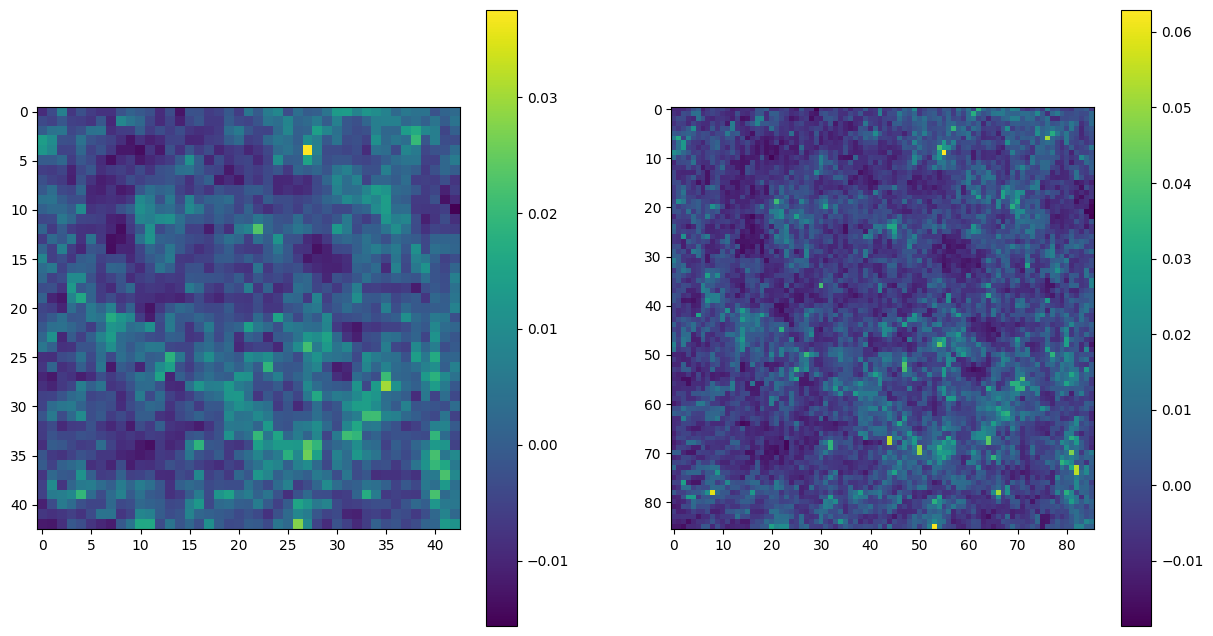

In [26]:
rebin_projection_nbody_store = rebin(projection_nbody_store[0])
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(rebin_projection_nbody_store);plt.colorbar();
plt.subplot(122)
plt.imshow(projection_nbody_store[0]);plt.colorbar();

2. Binary Fourier mask in Fourier space

In [27]:
import tensorflow as tf
import jax.numpy.fft as fft

def filter_cut(ngrid, reso_rad, cut_off):
    # from https://github.com/EiffL/LPTLensingComparison/blob/c4618d09b2b1df4b3b63799b304442f17bb709fd/jax_lensing/testf.py
    nsub = int(ngrid / 2 + 1)
    i, j = jnp.meshgrid(jnp.arange(nsub), jnp.arange(nsub))
    submatrix = 2 * jnp.pi * jnp.sqrt(i**2 + j**2) / reso_rad / jnp.float32(ngrid)

    result = jnp.zeros([ngrid, ngrid])
    result = result.at[0:nsub, 0:nsub].set(submatrix)
    result = result.at[0:nsub, nsub:].set(jnp.fliplr(submatrix[:, 1:-1]))
    result = result.at[nsub:, :].set(jnp.flipud(result[1:nsub-1, :]))
    tmp = jnp.around(result).astype(int)

    mask = jnp.ones_like(tmp)
    mask = mask.at[tmp > cut_off].set(0)
    return mask

reso_rad = reso / 60 / 180 * np.pi
f = filter_cut(N, reso_rad, 1000)
f_fft = tf.cast(f, tf.complex64)

2024-07-04 18:59:37.414721: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-07-04 18:59:38.202106: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-07-04 18:59:38.202171: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-07-04 18:59:38.202178: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

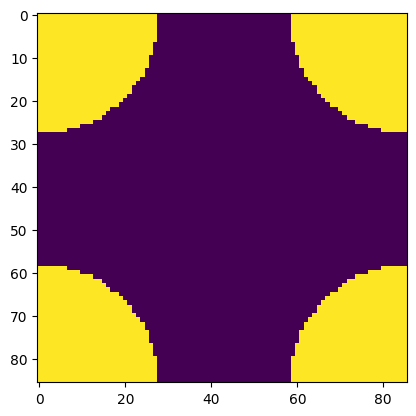

In [28]:
plt.imshow(abs(f_fft))

In [29]:
def filter2(ngrid, reso_rad, cut_off):
    nsub = ngrid
    i, j = jnp.meshgrid(jnp.arange(nsub), jnp.arange(nsub))
    submatrix = 2 * jnp.pi * jnp.sqrt((i-nsub/2)**2 + (j-nsub/2)**2) / reso_rad / jnp.float32(ngrid)
    submatrix = jnp.floor(jnp.fft.fftshift(submatrix))
    return jnp.where(submatrix>cut_off, 0., 1.)

def filter_tf(ngrid, reso_rad, cut_off):
    nsub = ngrid
    i, j = tf.meshgrid(tf.range(nsub), tf.range(nsub))
    submatrix = 2 * np.pi * tf.math.sqrt(tf.cast((i-nsub//2)**2 + (j-nsub//2)**2, tf.float32)) / reso_rad / ngrid
    submatrix = tf.math.floor(tf.signal.fftshift(submatrix))
    return tf.where(submatrix>cut_off, 0., 1.)

In [30]:
ngrid = N

In [31]:
nsub = ngrid
i, j = tf.meshgrid(tf.range(nsub), tf.range(nsub))
2 * np.pi *tf.math.sqrt(tf.cast((i-nsub//2)**2 + (j-nsub//2)**2, tf.float32))/ reso_rad / ngrid

<tf.Tensor: shape=(86, 86), dtype=float32, numpy=
array([[2189.2026, 2163.8962, 2138.897 , ..., 2114.2148, 2138.897 ,
        2163.8962],
       [2163.8962, 2138.2908, 2112.9883, ..., 2087.9998, 2112.9883,
        2138.2908],
       [2138.897 , 2112.9883, 2087.3792, ..., 2062.0806, 2087.3792,
        2112.9883],
       ...,
       [2114.2148, 2087.9998, 2062.0806, ..., 2036.4675, 2062.0806,
        2087.9998],
       [2138.897 , 2112.9883, 2087.3792, ..., 2062.0806, 2087.3792,
        2112.9883],
       [2163.8962, 2138.2908, 2112.9883, ..., 2087.9998, 2112.9883,
        2138.2908]], dtype=float32)>

In [32]:
mask_tf = filter_tf(86, reso_rad, 1000)
type(mask_tf)

tensorflow.python.framework.ops.EagerTensor

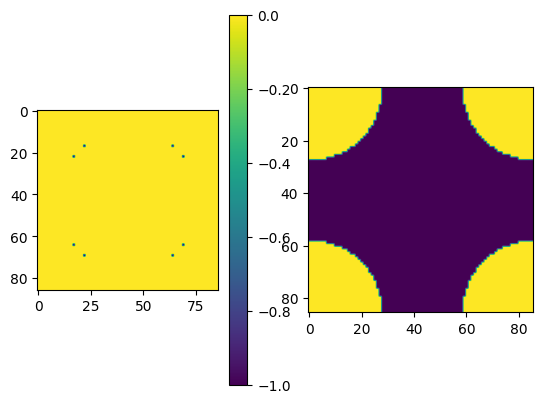

In [33]:
plt.subplot(121)
plt.imshow(f-mask_tf)
plt.colorbar()
plt.subplot(122)
plt.imshow(mask_tf)

In [34]:
def scale_cut_fn(kmap):
    reso_rad = reso / 60 / 180 * jnp.pi
    f = filter_cut(86, reso_rad, 1000)
    return fft.ifft2(fft.fft2(kmap)*f).real

In [35]:
f.shape

(86, 86)

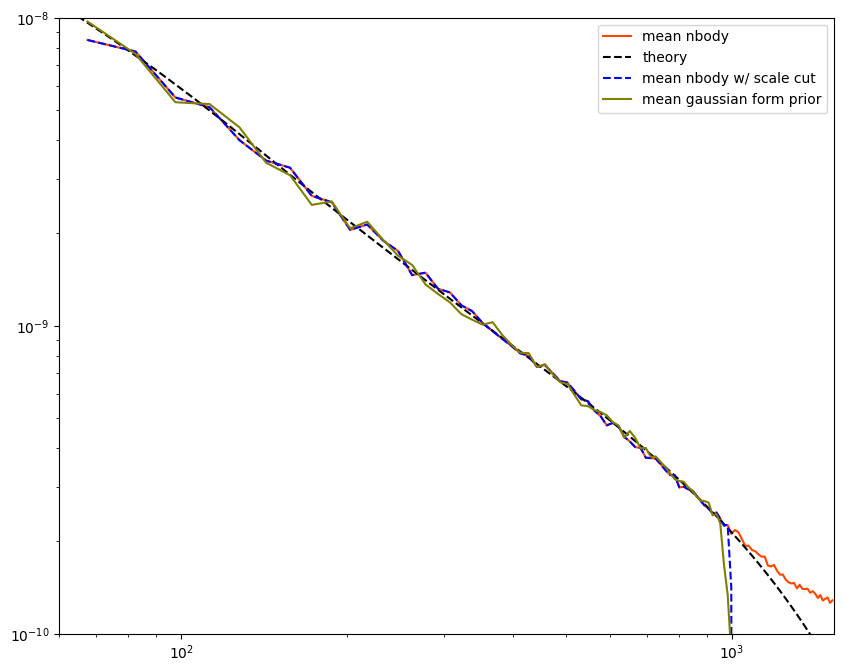

In [36]:
import astropy.units as u
from lenstools import ConvergenceMap
import numpy as np

plt.figure(figsize=(10,8))

# l_edges_kmap = np.arange(60.0, 2000.0, 15.0)
l_edges_kmap = np.arange(60.0, lmax, 15.0)

store_ps_gaussian = []
store_ps_nbody = []
store_ps_gaussian_prior = []
for i in range(0, nb_of_projected_map//2):
    rebin_projection_nbody_store = scale_cut_fn(projection_nbody_store[i])
    ell, ps = ConvergenceMap(rebin_projection_nbody_store, angle=map_size * u.deg).powerSpectrum(l_edges_kmap)
    ell2, ps2 = ConvergenceMap(projection_nbody_store[i], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)
    l, Pl = ConvergenceMap(gaussian_map_prior_store[i], angle=map_size * u.deg).powerSpectrum(l_edges_kmap)
    store_ps_gaussian_prior.append(Pl)

    store_ps_gaussian.append(ps)
    store_ps_nbody.append(ps2)
    # plt.loglog(ell,ps, alpha = 0.1, color='C0')
    # plt.loglog(ell, ps2, alpha = 0.1, color='orange')


plt.loglog(ell, jnp.mean(jnp.array(store_ps_nbody), axis = 0),  color='orangered', label = 'mean nbody')
plt.loglog(ell_theory, cell_theory*pixel_window_fn(ell_theory)**2, '--', c='k', label='theory')
plt.loglog(ell, jnp.mean(jnp.array(store_ps_gaussian), axis = 0), '--',  color='blue', label = 'mean nbody w/ scale cut')
plt.loglog(l, jnp.mean(jnp.array(store_ps_gaussian_prior), axis = 0),  color='olive', label = 'mean gaussian form prior')
plt.xlim([60, lmax])
plt.ylim([1e-10, 1e-8])
plt.legend()

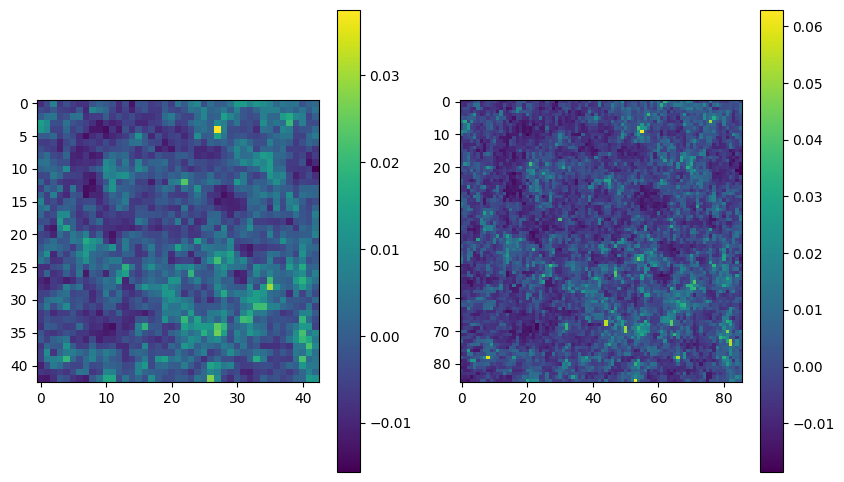

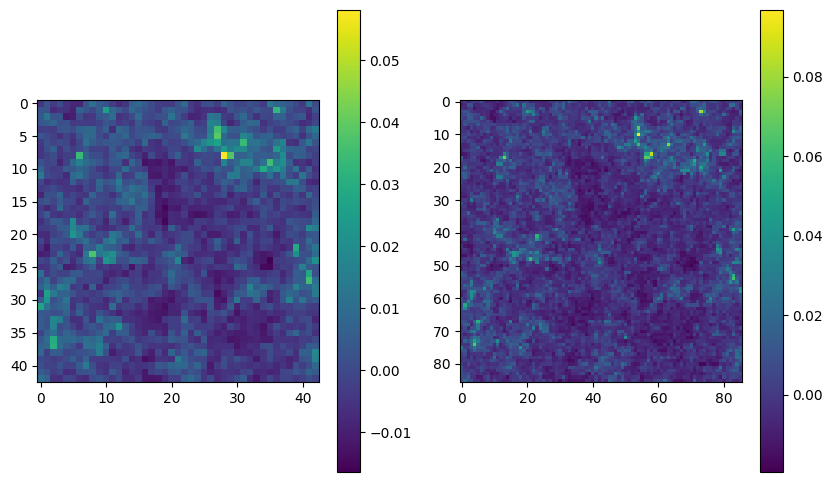

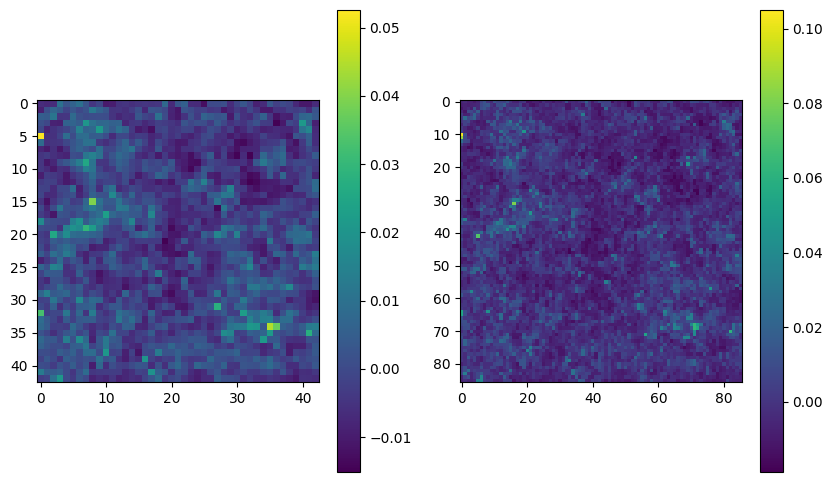

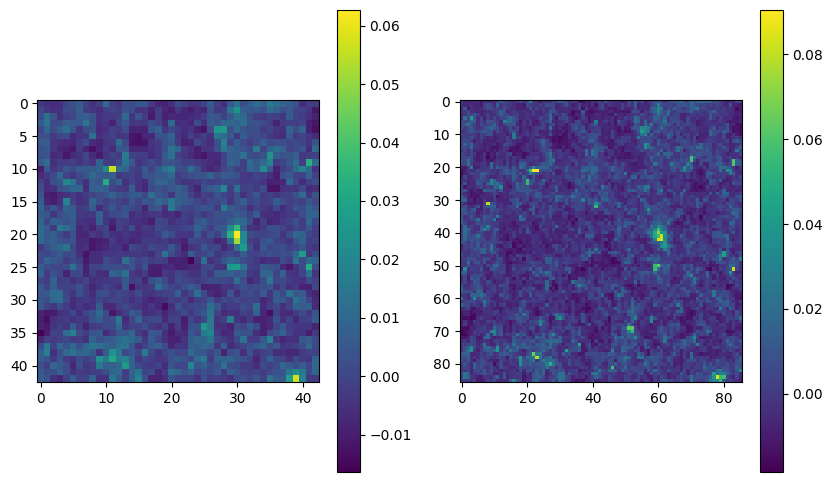

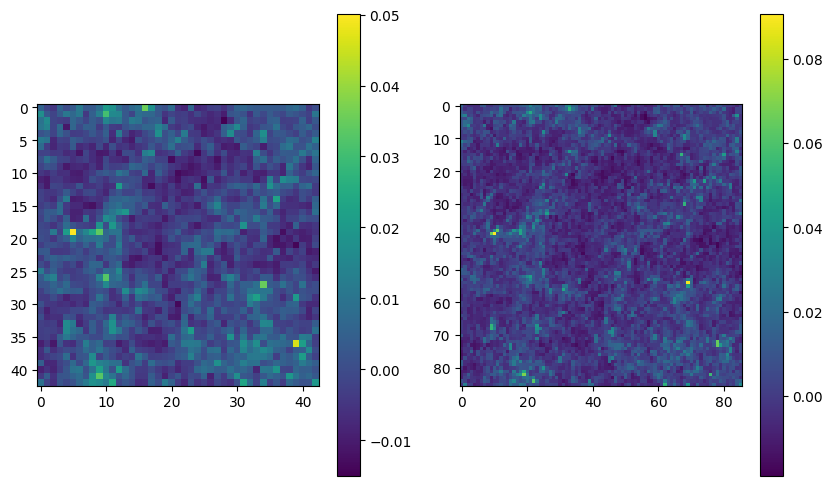

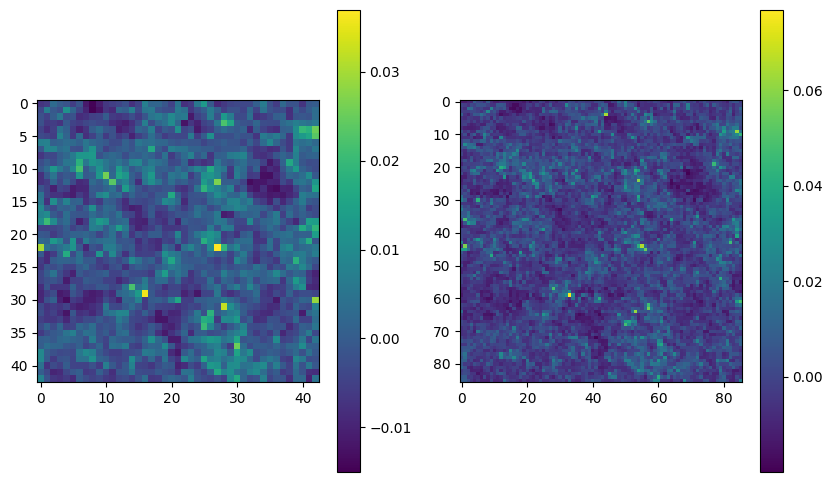

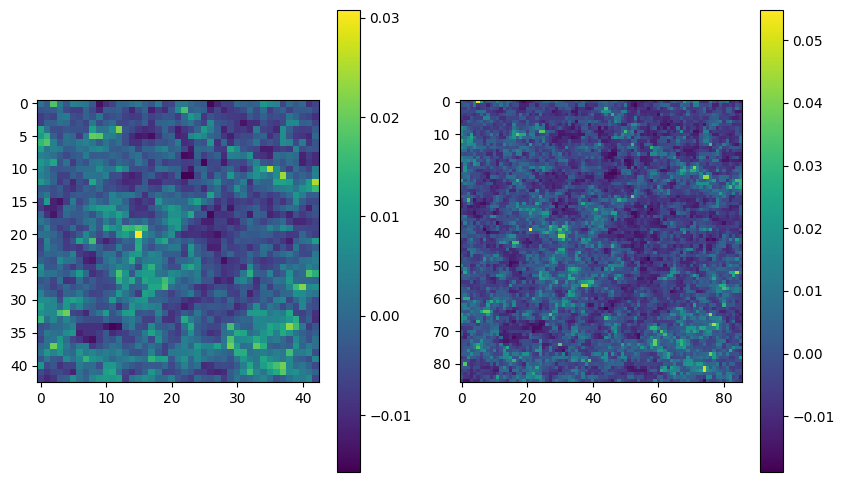

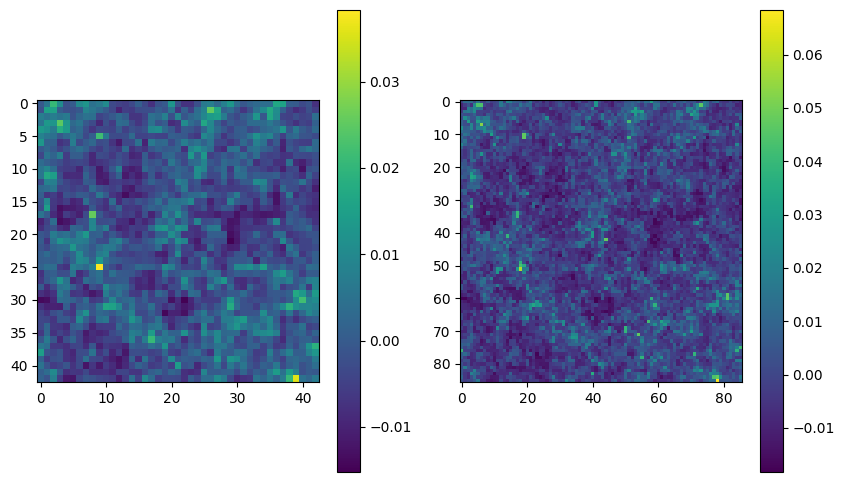

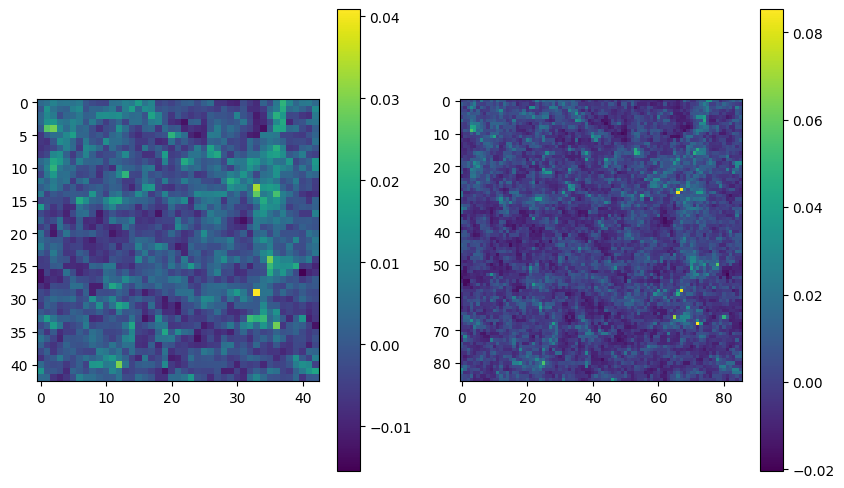

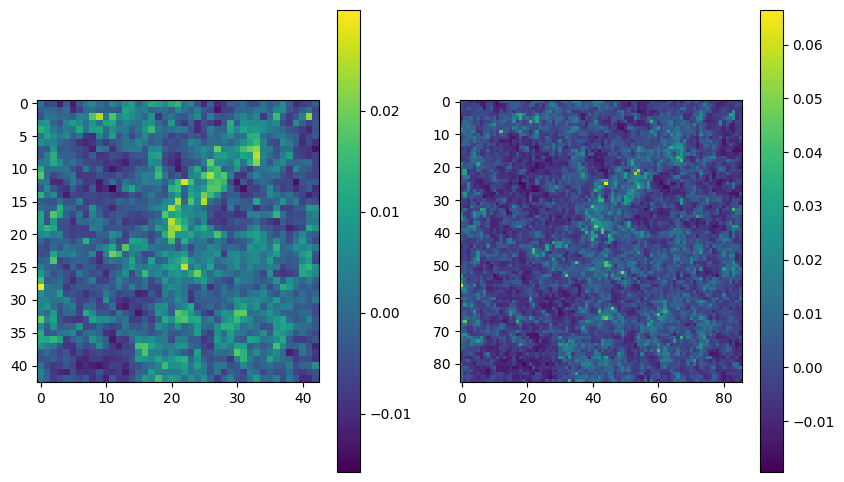

In [37]:
for i in range(10):
    rebin_projection_nbody_store = rebin(projection_nbody_store[i])
    plt.figure(figsize=(10,6))
    plt.subplot(121)
    plt.imshow(rebin_projection_nbody_store);plt.colorbar();
    plt.subplot(122)
    plt.imshow(projection_nbody_store[i]);plt.colorbar();

Alternative: rewritting the augmentation in jax

In [38]:
import dm_pix as pix

In [39]:
def apply_filter_jax(example):
    kmap = example["map_nbody"]
    kmap_fft = jnp.fft.fft2(kmap)
    mask_fft = f
    result = jnp.fft.ifft2(kmap_fft*mask_fft).real
    result -= result.mean()
    return {"map_nbody": result, "theta": example["theta"]}

def augmentation_noise_jax(
    example, key, sigma_e=0.26, galaxy_density=27, field_size=5, field_npix=86):
    x = example["map_nbody"]
    stddev=sigma_e / jnp.sqrt(galaxy_density * (field_size * 60 / field_npix) ** 2)
    x += jax.random.normal(key, shape=(field_npix,field_npix)) * stddev
    return {"maps": x, "theta": example["theta"]}

def augmentation_flip_jax(example, key):
    # x = example["maps"]
    x = example["map_nbody"]
    x = jnp.expand_dims(x, -1)
    x = pix.random_flip_left_right(key, x)
    _, key = jax.random.split(key, 2)
    x = pix.random_flip_up_down(key, x)   
    return {"maps": x[...,0], "theta": example["theta"]}

def rescale_h_jax(example):
    x = example["theta"]
    index_to_update = 3
    x = x.at[index_to_update].set(x[index_to_update] / 100)
    return {"maps": example["maps"], "theta": x}

def augment(batch, key):
    #batch = jax.vmap(augmentation_noise_jax, in_axes=({'map_nbody':0,
    #'theta':0}, 0))(batch, key)
    batch = jax.vmap(apply_filter_jax)(batch)
    key = jax.vmap(jax.random.split, in_axes=(0,None))(key, 2)[...,1]
    batch = jax.vmap(augmentation_flip_jax)(batch, key)
    batch = jax.vmap(rescale_h_jax)(batch)
    return batch

In [40]:
x = jnp.stack(projection_nbody_store[:6], 0)
batch = {"map_nbody":x, "theta":jnp.zeros((6,6))}
key = jax.random.split(jax.random.PRNGKey(0), 6)
test = augment(batch, key)

batch -0.00034024625
test 1.9341691e-10
batch -4.7112073e-05
test -3.7071574e-10
batch -0.00073419645
test -4.331733e-11


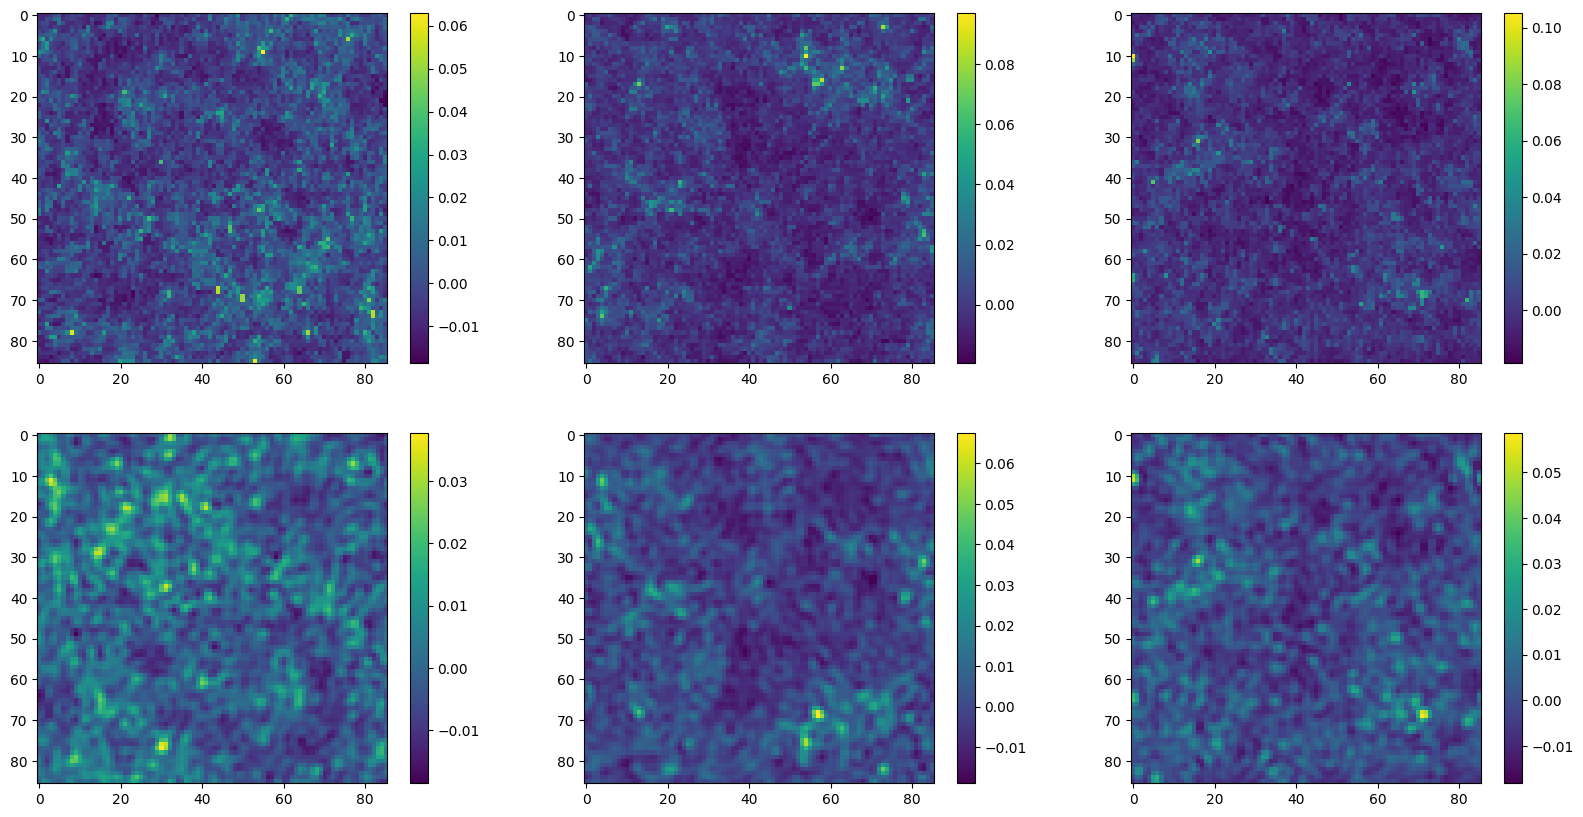

In [41]:
plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.imshow(batch["map_nbody"][i])
    print('batch', batch["map_nbody"][i].mean())
    plt.colorbar()
    plt.subplot(2,3,3+i+1)
    plt.imshow(test["maps"][i])
    print('test', test["maps"][i].mean())
    plt.colorbar()

Checking the prior with scale cut behaves ok

In [42]:
cosmo_fid = jc.Planck15()

pixel_window = jnp.array(hp.sphtfunc.pixwin(nside=nside), dtype='float32')

def pixel_window_fn(ell):
    return pixel_window[ell.astype('int32')]

def scale_cut_fn(ell, ell_cut=1000):
    return jnp.ones(lmax+1)[ell.astype('int32')].at[jnp.where(ell>ell_cut)].set(0)

def Pk_fn(k, cosmo, a_ai=None, pixel_window=True, scale_cut=1000):
    pz = smail_nz2(3.53, 4.49, 1.03, gals_per_arcmin2=galaxy_density)
    tracer = jc.probes.WeakLensing([pz], ia_bias=a_ai)
    ell_tab = jnp.logspace(0, 4.5, 128)
    cell_tab = jc.angular_cl.angular_cl(cosmo, ell_tab, [tracer])[0]
    if pixel_window is True:
        cell_tab *= pixel_window_fn(ell_tab)**2
    if scale_cut is not None:
        cell_tab *= scale_cut_fn(ell_tab, scale_cut)
    return jc.scipy.interpolate.interp(k.flatten(), ell_tab, cell_tab).reshape(k.shape)


def make_power_map(pk_fn, N, field_size, zero_freq_val=0.0):
    k = 2 * jnp.pi * jnp.fft.fftfreq(N, d=field_size / N)
    kcoords = jnp.meshgrid(k, k)
    k = jnp.sqrt(kcoords[0] ** 2 + kcoords[1] ** 2)
    ps_map = pk_fn(k)
    ps_map = ps_map.at[0, 0].set(zero_freq_val)
    return ps_map * (N / field_size) ** 2


P = partial(Pk_fn, cosmo=cosmo_fid, a_ai=None, scale_cut=None)

# Creating a power spectrum map
power_map = make_power_map(P, N, map_size_rad)
power_map = power_map.at[0, 0].set(1.0)

def log_gaussian_prior(map_data, ps_map=power_map, N=N):
    data_ft = jnp.fft.fft2(map_data).at[0, 0].set(0.0) / float(N)
    return -0.5 * jnp.sum(
        jnp.real(data_ft * jnp.conj(data_ft)) / (ps_map)
    )  # + jnp.log(jnp.sqrt(jnp.linalg.det(ps_map)))

In [43]:
jax.grad(log_gaussian_prior)(projection_nbody_store[i])

Array([[  13.936981 ,  -22.778534 ,   52.259827 , ...,  106.060486 ,
         -55.900192 ,   36.168304 ],
       [  62.57547  ,  -15.149315 ,   35.91754  , ..., -139.1033   ,
         180.22672  , -105.54979  ],
       [ 104.67255  ,    5.9086533,    2.3186035, ...,  100.224106 ,
        -131.43112  ,   14.670843 ],
       ...,
       [ -22.92382  , -756.8989   ,  522.7553   , ...,  -28.848743 ,
         -34.706352 ,  161.86966  ],
       [ 169.60449  ,  172.337    , -409.78763  , ...,   74.75087  ,
         -31.092808 ,  -35.612198 ],
       [  16.711021 ,  -68.86406  ,  142.8427   , ...,  -64.64917  ,
          58.137383 ,    6.39756  ]], dtype=float32)